<a href="https://colab.research.google.com/github/demotu/gait_score/blob/main/notebooks/gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gait Score Neuropathy (gait_score): ensemble

## Python setup

In [1]:
#import libraries
import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:55:29) [Clang 17.0.6 ] on darwin
 numpy 2.1.3
 scipy 1.14.1
 pandas 2.2.3
23/11/2024 16:16:35


In [22]:
# Environment configuration
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]
xr.set_options(keep_attrs=True)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

# angle convention
planes  = ['Sagittal', 'Frontal', 'Transverse']
labels_kin = np.array([['Pelvic Tilt ($^o$)\nposterior(-)/anterior(+)',
                        'Pelvic Obliquity ($^o$)\ndown(-)/up(+)',
                        'Pelvic Rotation ($^o$)\nexternal(-)/internal(+)'],
                       ['Hip Flexion ($^o$)\nextension(-)/flexion(+)',
                        'Hip Adduction ($^o$)\nabduction(-)/adduction(+)',
                        'Hip Rotation ($^o$)\nexternal(-)/internal(+)'],
                       ['Knee Flexion ($^o$)\nextension(-)/flexion(+)',
                        'Ankle Dorsiflexion ($^o$)\nplantarflexion(-)/dorsiflexion(+)',
                        'Foot Progression ($^o$)\ninternal(-)/external(+)']])
labels_mom = np.array([['Hip ($Nm/BM$)\next(-)/flex(+)',
                        'Knee ($Nm/BM$)\next(-)/flex(+)',
                        'Ankle ($Nm/BM$)\nplantarflex(-)/dorsiflex(+)',
                        'Support ($Nm/BM$)\next(-)/flex(+)']]).T

if (path := Path('/home/marcos/adrive/Python/projects/labimph/gait_score')).exists() is False:
    path = Path('/users/marcos/adrive/Python/projects/labimph/gait_score')
print(f'Path: {path}')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

Path: /users/marcos/adrive/Python/projects/labimph/gait_score


## Helping functions

In [23]:
def read_data(path2, fname, variable):
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/metadata_{fname}.csv'
        print(f'Loading data from {url}')
        metadata = pd.read_csv(url, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    else:
        metadata = pd.read_csv(path2 /  f'metadata_{fname}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://github.com/demotu/gait_score/raw/refs/heads/main/data/{variable}_{fname}.nc'
        #print(f'Loading data from {url}')
        !wget {url}
        da = xr.open_dataarray(f'{variable}_{path2.name}.nc')
    else:
        da = xr.open_dataarray(path2 / f'{variable}_{fname}.nc')    
    return metadata, da
    
    

def plot_ensembles(da2, metadata, path2, mean=False, labels=None, ref=None, variable=None):
    """3x3 suplots with joint angles of all subjects for the GPS calculation.
    """

    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)

    NS = metadata['Subject'].unique().size
    NT = metadata['Subject'].shape[0]
    fig, axs = plt.subplots(len(joints), len(axes), figsize=(len(axes)*4, 9), sharex=True, squeeze=False)
    text = f'{path2.name}:'
    if ref is not None:
        ref_m =  ref.values[:, 0::2]
        ref_sd = ref.values[:, 1::2]
    if mean:
        text = f'Joint {variable} during walking (mean$\\pm$1SD across subjects, {NS} subjects with neuropathy) and mean of control'
    else:
        text = f'Subjects\' joint {variable} during walking (median across trials, {NS} subjects, {NT} trials)'
    fig.suptitle(text, fontsize=12)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            
            if ref is not None:
                axs[j, xyz].plot(time, ref_m[:, len(axes)*j+xyz], color=colors[1], alpha=.5, lw=3, label='Control')
                axs[j, xyz].fill_between(time,
                                         ref_m[:, len(axes)*j+xyz] + ref_sd[:, len(axes)*j+xyz],
                                         ref_m[:, len(axes)*j+xyz] - ref_sd[:, len(axes)*j+xyz],
                                         facecolor=colors[1], alpha=.3, edgecolor='none')
            
            if mean:
                dam = da2.reduce(np.nanmean, dim='Subject')
                dastd = da2.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)
                axs[j, xyz].plot(time, dam.sel(Joint=joints[j], Axis=axes[xyz]), color=colors[0], alpha=.8, lw=3, label='Neuropathy')
                axs[j, xyz].fill_between(time,
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) + dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) - dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         facecolor=colors[0], alpha=.6, edgecolor='none')
            else:
                axs[j, xyz].plot(time, da2.sel(Joint=joints[j], Axis=axes[xyz]), alpha=.6, lw=2)

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    if ref is not None:
        axs[0, 0].legend(loc='upper right', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        if mean:
            fig.savefig(f'{path2}Angles_msd_Subjects.png', bbox_inches='tight')
        else:
            fig.savefig(f'{path2}AnglesSubjectsG.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()


### Reference data

In [24]:
# reference data from Claudiane
path2 = path / 'data/Claudiane'
if os.getenv("COLAB_RELEASE_TAG"):
    url = 'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Claudiane/angles_mom_ref_gp19b.csv'
    ref_data = pd.read_csv(url, index_col=0)
else:
    ref_data = pd.read_csv(path2 / 'angles_mom_ref_gp19b.csv', index_col=0)
# kinematics for GPS
ref_data_kin = ref_data[['Pelvis_Z_m', 'Pelvis_Z_sd', 'Pelvis_X_m', 'Pelvis_X_sd', 'Pelvis_Y_m', 'Pelvis_Y_sd',
                         'Hip_Z_m', 'Hip_Z_sd', 'Hip_X_m', 'Hip_X_sd', 'Hip_Y_m', 'Hip_Y_sd',
                         'Knee_Z_m', 'Knee_Z_sd', 'Ankle_Z_m', 'Ankle_Z_sd', 'Foot_Y_m', 'Foot_Y_sd']]
# moments for GPS
ref_data_mom = ref_data[['HipMoment_Z_m', 'HipMoment_Z_sd',
                         'KneeMoment_Z_m', 'KneeMoment_Z_sd',
                         'AnkleMoment_Z_m', 'AnkleMoment_Z_sd',
                         'SupportMoment_Z_m', 'SupportMoment_Z_sd']]

### Project ERJ

In [26]:
path2 = path / 'data'
variable = 'Angle'
metadata, da_kin = read_data(path2, fname='ERJ_T00', variable=variable)
display(da_kin)

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 10, Subject: 105)> Size: 4MB
[481950 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

### Plots

/Users/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


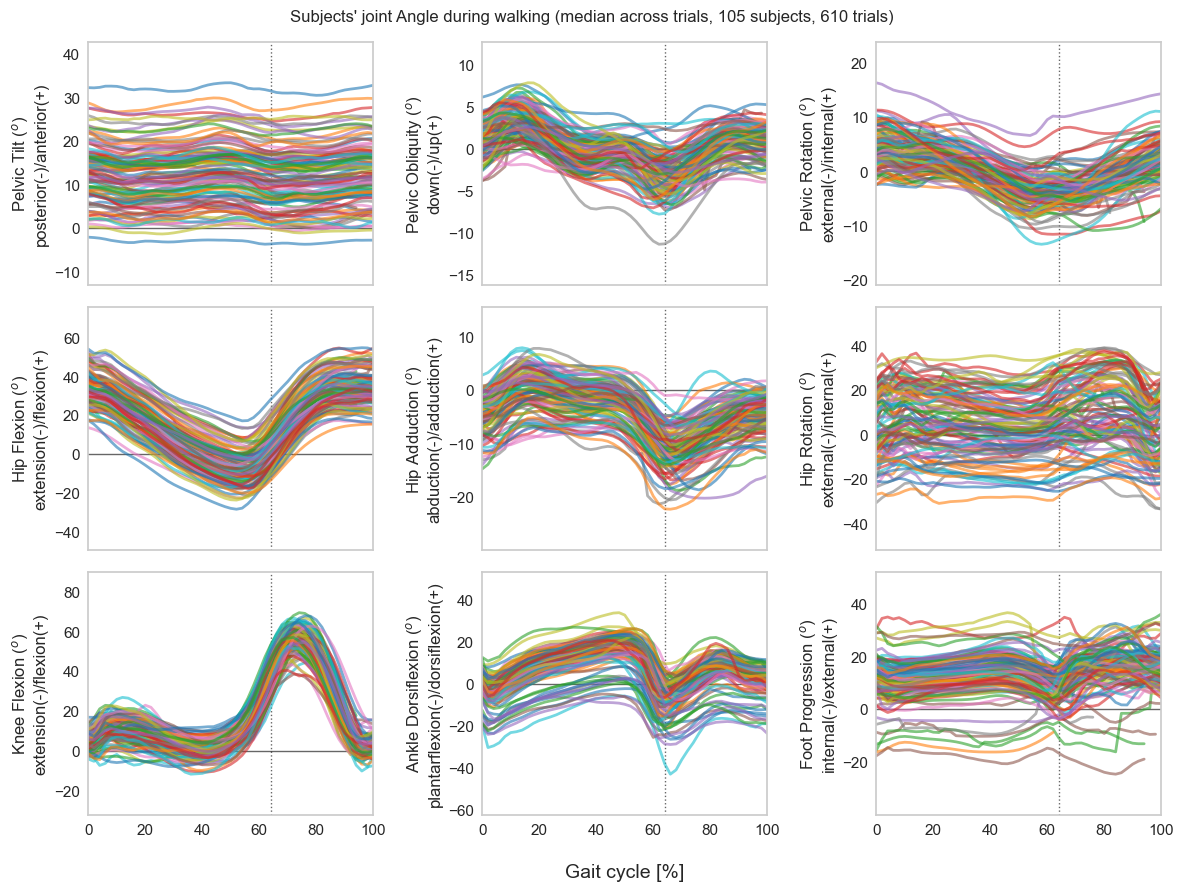

In [27]:
da2 = da_kin.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')
plot_ensembles(da2, metadata, path2, labels=labels_kin, variable=variable)

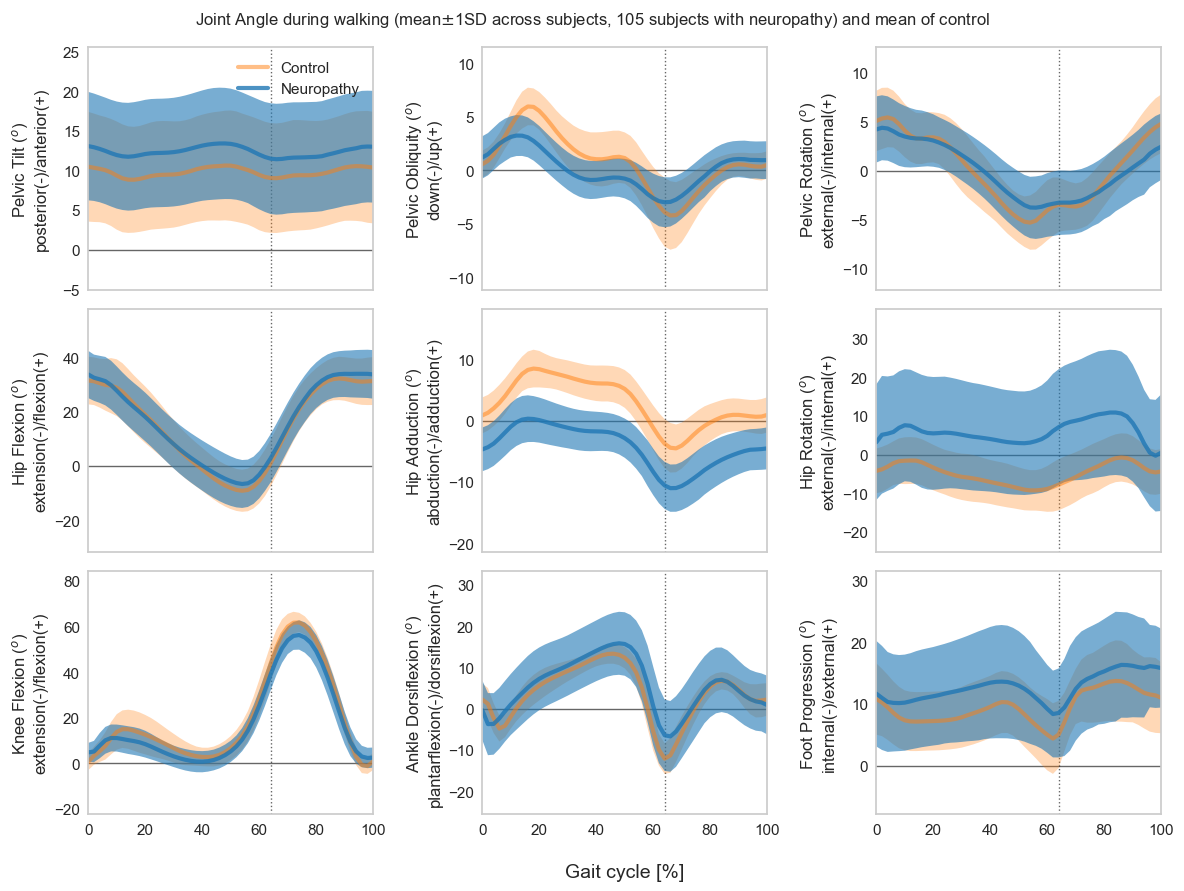

In [28]:
plot_ensembles(da2, metadata, path2, mean=True, labels=labels_kin, ref=ref_data_kin, variable=variable)

In [29]:
variable = 'Moment'
metadata, da_mom = read_data(path2, fname='ERJ_T00', variable=variable)
display(da_mom)

<xarray.DataArray 'Moment' (Time: 51, Joint: 4, Axis: 1, Trial: 10, Subject: 105)> Size: 2MB
[214200 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 32B 'Hip' 'Knee' 'Ankle' 'Support'
  * Axis     (Axis) object 8B 'ML'
Attributes:
    units:    Nm/(BM*H)

/Users/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


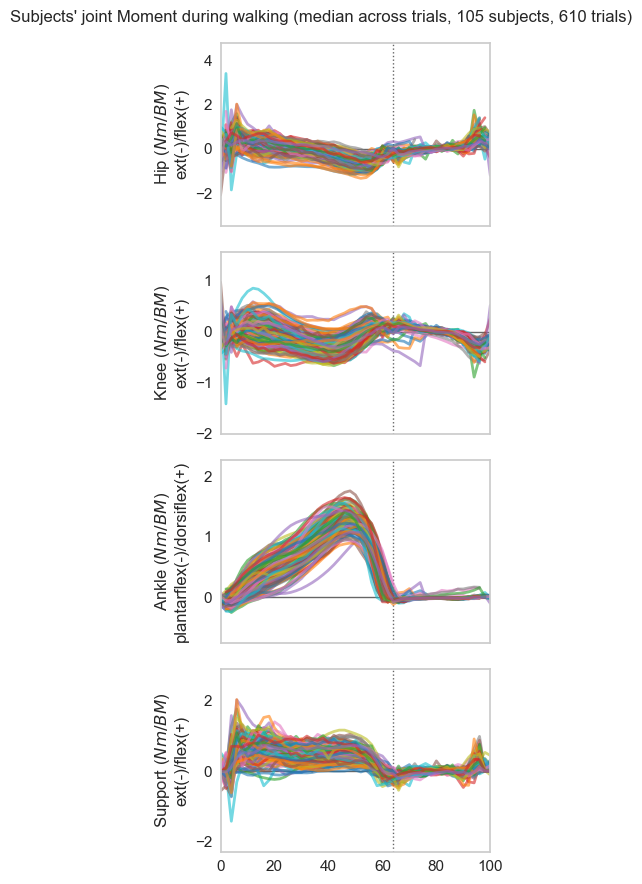

In [30]:
da2 = da_mom.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')
plot_ensembles(da2, metadata, path2, labels=labels_mom, variable=variable)

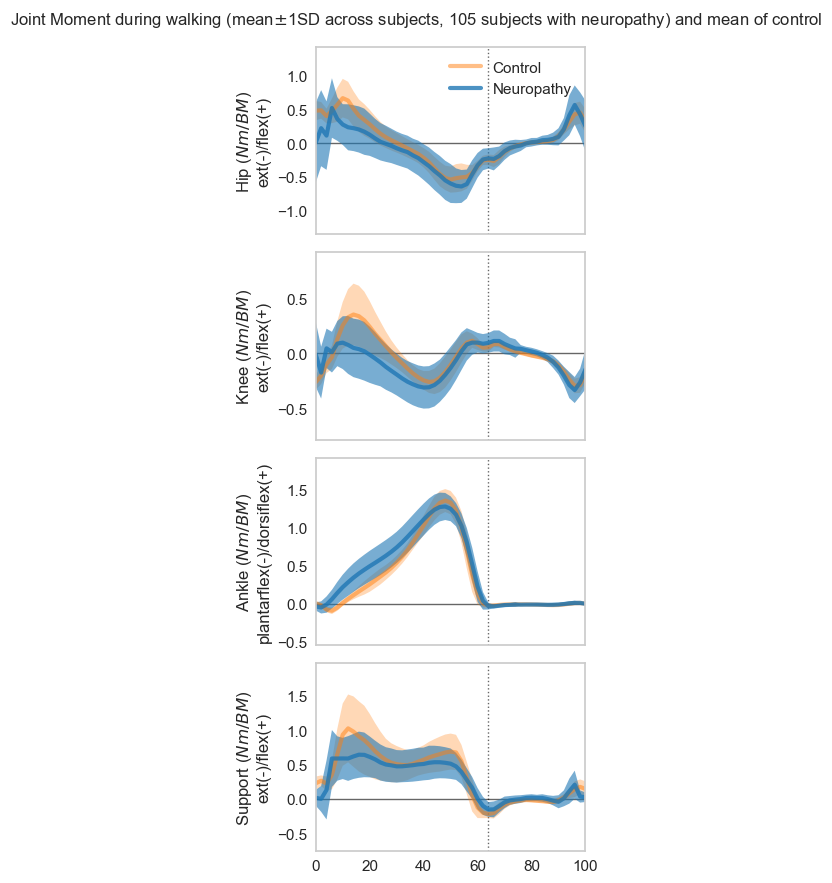

In [31]:
plot_ensembles(da2, metadata, path2, mean=True, labels=labels_mom, ref=ref_data_mom, variable=variable)